### Setup

In [1]:
from pathlib import Path
from numpy import concatenate, array, expand_dims, mean, sum
from sklearn.model_selection import train_test_split
import os
import time
import tensorflow as tf

In [2]:
gpu = tf.config.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

2024-11-15 18:44:22.267179: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-15 18:44:24.666220: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-15 18:44:24.666611: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
data_root = Path("../data/Monkeypox_Data/Original_Images")    # points to the folder containing the images that will be used for training

# hyperparameters
batch_size = 32         # size of the batch that will be fed to model
img_height = 224        # input image height
img_width = 224         # input image width
test_size = 0.2

# Load dataset without splitting
dataset = tf.keras.utils.image_dataset_from_directory(
    data_root,                                  # loads images from the data_root directory
    image_size=(img_height, img_width),         # resizes all images to (224, 224) pixels
    batch_size=batch_size,                      # set the batch size
    shuffle=False                                # shufle data when loaded
)

# normalization_layer = layers.Rescaling(1./255)
# dataset = dataset.map(lambda x, y: (normalization_layer(x), y))

Found 228 files belonging to 2 classes.


2024-11-15 18:44:28.927808: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-15 18:44:28.928249: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-15 18:44:28.928480: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-15 18:44:29.097151: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-15 18:44:29.097722: I external/local_xla/xla/stream_executor

In [4]:
image_batches, labels = [], []
for image_batch, label_batch in dataset:
    image_batches.append(image_batch)
    labels.append(label_batch)

image_batches = concatenate(image_batches) # Flatten batches to get all images
labels = concatenate(labels)               # Flatten batches to get all labels  
print(f"Total Images: {image_batches.shape[0]} \nTotal Labels: {labels.shape[0]}")

# Split the data into test subset for benchmarking
_, X_test, _, Y_test = train_test_split(image_batches, labels, test_size=test_size, random_state=42)


X_test = X_test / 255.0


Total Images: 228 
Total Labels: 228


2024-11-15 18:44:32.053281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Define Functions

In [5]:
def get_model_size(model_dir):
    total_size = 0
    for dirpath, _, filenames in os.walk(model_dir):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size / (1024 * 1024)  # Convert to MB

In [6]:
def measure_inference_time(model, X_test, batch_size, trials=50):
    inference_times = []

    num_batches = len(X_test) // batch_size

    # Warm-up phase (Run a few trials to initialize the model)
    print(f"Running {10} warm-up trials to initialize the model...")
    for _ in range(10):
        for j in range(num_batches):
            batch_start = j * batch_size
            batch_end = (j + 1) * batch_size
            batch_images = X_test[batch_start:batch_end]  # Get a batch of images
            dummy_input = tf.convert_to_tensor(batch_images) # Ensure the batch is in tensor format
            model.signatures["serving_default"](tf.convert_to_tensor(dummy_input))
            tf.keras.backend.clear_session()

    print(f"Running {trials} inference trials on {len(X_test)} test images...")
    for i in range(trials):
        start_time = time.perf_counter()

        # Loop over the batches of X_test
        for j in range(num_batches):
            batch_start = j * batch_size
            batch_end = (j + 1) * batch_size
            batch_images = X_test[batch_start:batch_end]  # Get a batch of images
            inputs = tf.convert_to_tensor(batch_images) # Ensure the batch is in tensor format

            # Run inference for the batch
            model.signatures["serving_default"](inputs)  # Perform inference directly
            tf.keras.backend.clear_session()

        end_time = time.perf_counter()
        inference_time = end_time - start_time
        inference_times.append(inference_time)

        if i % 10 == 0:
            avg_inference = mean(inference_times)  # Average inference time per trial
            print(f"Step {i}: average inference time = {avg_inference:.6f} seconds")

    tf.keras.backend.clear_session()

    # Compute throughput (images per second)
    total_time = sum(inference_times)
    throughput = (trials * len(X_test)) / total_time
    return mean(inference_times), throughput

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_metrics(model, X_test, Y_test, batch_size):
    print(f"Evaluating metrics on {len(X_test)} test images...")
    
    num_batches = len(X_test) // batch_size
    all_predicted_classes = []

    # Loop over the test dataset in batches
    for j in range(num_batches):
        batch_start = j * batch_size
        batch_end = (j + 1) * batch_size
        batch_images = X_test[batch_start:batch_end]
        inputs = tf.convert_to_tensor(batch_images)  # Convert batch to tensor

        # Run predictions
        result = model.signatures["serving_default"](inputs)  # Inference
        prediction_logits = result["output_0"].numpy()  # Extract logits
        probabilities = tf.nn.sigmoid(prediction_logits).numpy()  # Apply sigmoid
        predicted_classes = (probabilities > 0.5).astype(int)  # Threshold for binary classification

        # Collect predictions
        all_predicted_classes.extend(predicted_classes)

    # Handle any remaining images that don't fit evenly in batches
    remaining_samples = len(X_test) % batch_size
    if remaining_samples > 0:
        batch_images = X_test[-remaining_samples:]
        inputs = tf.convert_to_tensor(batch_images)
        result = model.signatures["serving_default"](inputs)
        prediction_logits = result["output_0"].numpy()
        probabilities = tf.nn.sigmoid(prediction_logits).numpy()
        predicted_classes = (probabilities > 0.5).astype(int)
        all_predicted_classes.extend(predicted_classes)

    # Flatten predictions and labels to ensure they are 1D arrays
    all_predicted_classes = array(all_predicted_classes).flatten()
    Y_test = array(Y_test).flatten()

    # Ensure the number of predictions matches the number of ground truth labels
    if len(all_predicted_classes) != len(Y_test):
        raise ValueError(f"Number of predicted classes ({len(all_predicted_classes)}) "
                         f"does not match the number of ground truth labels ({len(Y_test)}).")

    # Calculate metricsimport numpy as np

    accuracy = accuracy_score(Y_test, all_predicted_classes)
    precision = precision_score(Y_test, all_predicted_classes, average="binary")
    recall = recall_score(Y_test, all_predicted_classes, average="binary")
    f1 = f1_score(Y_test, all_predicted_classes, average="binary")

    # Output metrics
    metrics_dict = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
    }

    print(f"Metrics: {metrics_dict}")
    return metrics_dict

### Benchmarking

In [8]:
# Initialize storage for results
model_sizes = {}
average_times = {}
throughputs = {}
metrics = {}

file_path = '../tensorRT_model/saved_values/values.json'

In [9]:
from json import load, dump

def save_or_update_json(new_data, file_path):
    """
    Save new data to a JSON file. If the file exists, load its content,
    update it with the new data, and save it back.
    """
    # Check if the file already exists
    if os.path.exists(file_path):
        with open(file_path, 'r') as json_file:
            existing_data = load(json_file)  # Load existing data
    else:
        existing_data = {}  # Start with an empty dictionary if file doesn't exist

    # Update existing data with the new data
    for key, value in new_data.items():
        if key in existing_data:
            existing_data[key].update(value)  # Merge dictionaries
        else:
            existing_data[key] = value  # Add new key

    # Save the updated data back to the file
    with open(file_path, 'w') as json_file:
        dump(existing_data, json_file, indent=4)
    print(f"Data updated and saved to {file_path}")


In [ ]:
model_name = "Original"
model = tf.saved_model.load('../best_model/model1/best_f1score_fold')
model_sizes[model_name] = get_model_size('../best_model/model1/best_f1score_fold')

# Measure inference time and throughput
print(f'Checking inference time for {model_name} model')
avg_time, throughput = measure_inference_time(model, X_test, batch_size=batch_size)
average_times[model_name] = avg_time
throughputs[model_name] = throughput

# Measure metrics
metrics[model_name] = measure_metrics(
    model=model,
    X_test=X_test,
    Y_test=Y_test,
    batch_size=batch_size,
)

new_data = {
    "model_sizes": {model_name: model_sizes[model_name]},
    "average_times": {model_name: average_times[model_name]},
    "throughputs": {model_name: throughputs[model_name]},
    "metrics": {model_name: metrics[model_name]},
}

save_or_update_json(new_data, file_path)

In [ ]:
model_name = "FP32"
model = tf.saved_model.load('../tensorRT_model/fp32')
model_sizes[model_name] = get_model_size('../tensorRT_model/fp32')

# Measure inference time and throughput
print(f'Checking inference time for {model_name} model')
avg_time, throughput = measure_inference_time(model, X_test, batch_size=batch_size)
average_times[model_name] = avg_time
throughputs[model_name] = throughput

# Measure metrics
metrics[model_name] = measure_metrics(
    model=model,
    X_test=X_test,
    Y_test=Y_test,
    batch_size=batch_size,
)

new_data = {
    "model_sizes": {model_name: model_sizes[model_name]},
    "average_times": {model_name: average_times[model_name]},
    "throughputs": {model_name: throughputs[model_name]},
    "metrics": {model_name: metrics[model_name]},
}

save_or_update_json(new_data, file_path)

In [ ]:
model_name = "FP16"
model = tf.saved_model.load('../tensorRT_model/fp16')
model_sizes[model_name] = get_model_size('../tensorRT_model/fp16')

# Measure inference time and throughput
print(f'Checking inference time for {model_name} model')
avg_time, throughput = measure_inference_time(model, X_test, batch_size=batch_size)
average_times[model_name] = avg_time
throughputs[model_name] = throughput

# Measure metrics
metrics[model_name] = measure_metrics(
    model=model,
    X_test=X_test,
    Y_test=Y_test,
    batch_size=batch_size,
)

new_data = {
    "model_sizes": {model_name: model_sizes[model_name]},
    "average_times": {model_name: average_times[model_name]},
    "throughputs": {model_name: throughputs[model_name]},
    "metrics": {model_name: metrics[model_name]},
}

save_or_update_json(new_data, file_path)

In [10]:
model_name = "INT8"
model = tf.saved_model.load('../tensorRT_model/int8')
model_sizes[model_name] = get_model_size('../tensorRT_model/int8')

# Measure inference time and throughput
print(f'Checking inference time for {model_name} model')
avg_time, throughput = measure_inference_time(model, X_test, batch_size=batch_size)
average_times[model_name] = avg_time
throughputs[model_name] = throughput

# Measure metrics
metrics[model_name] = measure_metrics(
    model=model,
    X_test=X_test,
    Y_test=Y_test,
    batch_size=batch_size,
)

new_data = {
    "model_sizes": {model_name: model_sizes[model_name]},
    "average_times": {model_name: average_times[model_name]},
    "throughputs": {model_name: throughputs[model_name]},
    "metrics": {model_name: metrics[model_name]},
}

save_or_update_json(new_data, file_path)

Checking inference time for INT8 model
Running 10 warm-up trials to initialize the model...


2024-11-15 18:45:06.513048: W tensorflow/compiler/tf2tensorrt/kernels/trt_engine_op.cc:971] TF-TRT Warning: Engine retrieval for input shapes: [[32,224,224,3]] failed. Running native segment for PartitionedCall/TRTEngineOp_006_000
2024-11-15 18:45:06.811863: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 90300
2024-11-15 18:45:12.580513: W tensorflow/compiler/tf2tensorrt/kernels/trt_engine_op.cc:971] TF-TRT Warning: Engine retrieval for input shapes: [[32,224,224,3]] failed. Running native segment for PartitionedCall/TRTEngineOp_006_000
2024-11-15 18:45:13.179347: W tensorflow/compiler/tf2tensorrt/kernels/trt_engine_op.cc:971] TF-TRT Warning: Engine retrieval for input shapes: [[32,224,224,3]] failed. Running native segment for PartitionedCall/TRTEngineOp_006_000
2024-11-15 18:45:13.783235: W tensorflow/compiler/tf2tensorrt/kernels/trt_engine_op.cc:971] TF-TRT Warning: Engine retrieval for input shapes: [[32,224,224,3]] failed. Running native segmen

Running 50 inference trials on 46 test images...
Step 0: average inference time = 0.604753 seconds
Step 10: average inference time = 0.595722 seconds
Step 20: average inference time = 0.608572 seconds
Step 30: average inference time = 0.609956 seconds
Step 40: average inference time = 0.615856 seconds
Evaluating metrics on 46 test images...
Metrics: {'accuracy': 0.9782608695652174, 'precision': 0.967741935483871, 'recall': 1.0, 'f1_score': 0.9836065573770492}
Data updated and saved to ../tensorRT_model/saved_values/values.json


In [12]:
with open(file_path, 'r') as json_file:
    combined_data = load(json_file)
    
model_sizes = combined_data.get("model_sizes", {})
# Calculate compression ratios and speedup factors
compression_ratios = {
    model: model_sizes["Original"] / size
    for model, size in model_sizes.items() if model != "Original"
}

speedup_factors = {
    model: average_times["Original"] / time
    for model, time in average_times.items() if model != "Original"
}

NameError: name 'combined_data' is not defined

### Compute Graphs

In [13]:
from pandas import DataFrame, melt

with open(file_path, 'r') as json_file:
    combined_data = load(json_file)
    
# Access individual components    
model_sizes = combined_data.get("model_sizes", {})
average_times = combined_data.get("average_times", {})
throughputs = combined_data.get("throughputs", {})
metrics = combined_data.get("metrics", {})

# Calculate compression ratios and speedup factors
compression_ratios = {
    model: model_sizes["Original"] / size
    for model, size in model_sizes.items() if model != "Original"
}

speedup_factors = {
    model: average_times["Original"] / time
    for model, time in average_times.items() if model != "Original"
}

# Example Data (Replace with your actual data)
models = ["Original", "FP32", "FP16", "INT8"]
model_sizes_data = [model_sizes[model] for model in models]
throughputs_data = [throughputs[model] for model in models]
average_times_data = [average_times[model] for model in models]

# Dictionary to store metrics for all models
metrics_data = {model: metrics[model] for model in models}

# Prepare DataFrames for sizes and throughputs
model_sizes_df = DataFrame({
    "Model": models,
    "Size (MB)": model_sizes_data
})

throughputs_df = DataFrame({
    "Model": models,
    "Throughput (images/second)": throughputs_data
})

average_times_df = DataFrame({
    "Model": models,
    "Average Inference Time (Seconds)": average_times_data
})

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot model sizes
def graph_model_size(model_sizes):
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=model_sizes, x="Model", y="Size (MB)", palette="muted")
    plt.title("Model Sizes Comparison")
    plt.ylabel("Size (MB)")
    plt.xlabel("Model")
    # Annotate each bar with its height
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,
            p.get_height(),
            f'{p.get_height():.2f}',
            ha='center', va='bottom', fontsize=10
        )
    plt.tight_layout()
    plt.savefig("../tensorRT_model/metrics/model_sizes.png")
    plt.show()

# Function to plot throughputs
def graph_throughput(throughputs):
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=throughputs, x="Model", y="Throughput (images/second)", palette="muted")
    plt.title("Model Throughput Comparison")
    plt.ylabel("Throughput (images/second)")
    plt.xlabel("Model")
    # Annotate each bar with its height
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,
            p.get_height(),
            f'{p.get_height():.2f}',
            ha='center', va='bottom', fontsize=10
        )
    plt.tight_layout()
    plt.savefig("../tensorRT_model/metrics/throughput_comparison.png")
    plt.show()

def graph_inference_times(average_times_df):
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=average_times_df, x="Model", y="Average Inference Time (Seconds)", palette="muted")
    plt.title("Average Inference Time Comparison")
    plt.ylabel("Inference Time (Seconds)")
    plt.xlabel("Model")
    # Annotate each bar with its height
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,
            p.get_height(),
            f'{p.get_height():.2f}',
            ha='center', va='bottom', fontsize=10
        )
    plt.tight_layout()
    plt.savefig("../tensorRT_model/metrics/average_inference_comparison.png")
    plt.show()

# Function to compare metrics across models
def graph_metrics(metrics_data):
    # Convert metrics data into a DataFrame
    metrics_df = DataFrame(metrics_data).T.reset_index()
    metrics_df = metrics_df.rename(columns={"index": "Model"})

    # Melt for plotting
    metrics_long = melt(
        metrics_df, id_vars=["Model"], 
        var_name="Metric", value_name="Value"
    )

    # Grouped Bar Chart for Metrics
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=metrics_long, x="Metric", y="Value", hue="Model", palette="muted")
    plt.title("Metrics Comparison")
    plt.ylabel("Value")
    plt.xlabel("Metric")
    # Annotate each bar with its height
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,
            p.get_height(),
            f'{p.get_height():.2f}',
            ha='center', va='bottom', fontsize=10
        )
    plt.legend(title="Model")
    plt.tight_layout()
    plt.savefig("../tensorRT_model/metrics/metrics_comparison.png")
    plt.show()

    print("\nDetailed Metric Changes:")
    print(metrics_df)

/tmp/ipykernel_4522/4233752847.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=model_sizes, x="Model", y="Size (MB)", palette="muted")


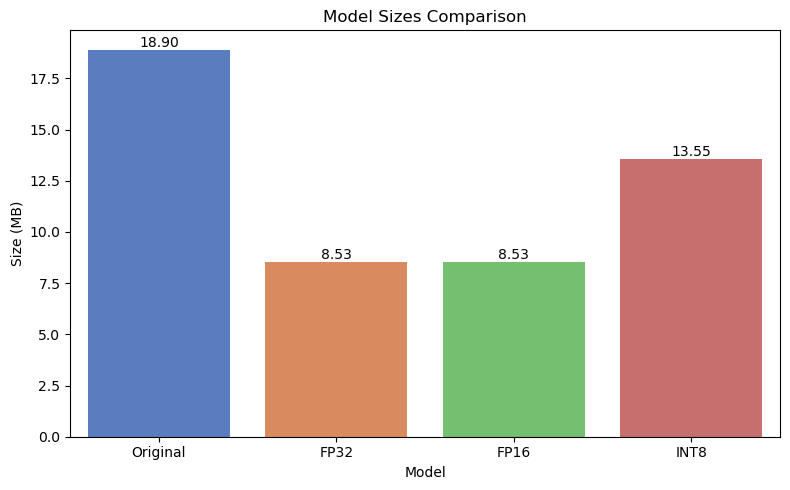

/tmp/ipykernel_4522/4233752847.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=throughputs, x="Model", y="Throughput (images/second)", palette="muted")


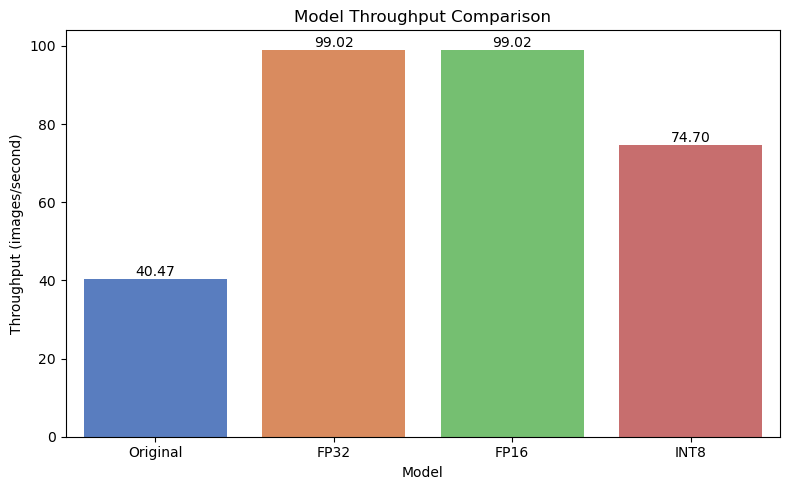

/tmp/ipykernel_4522/4233752847.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=average_times_df, x="Model", y="Average Inference Time (Seconds)", palette="muted")


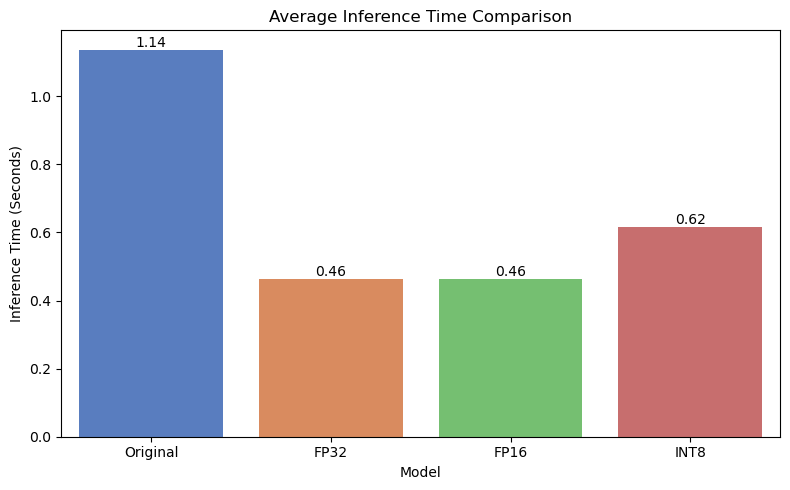

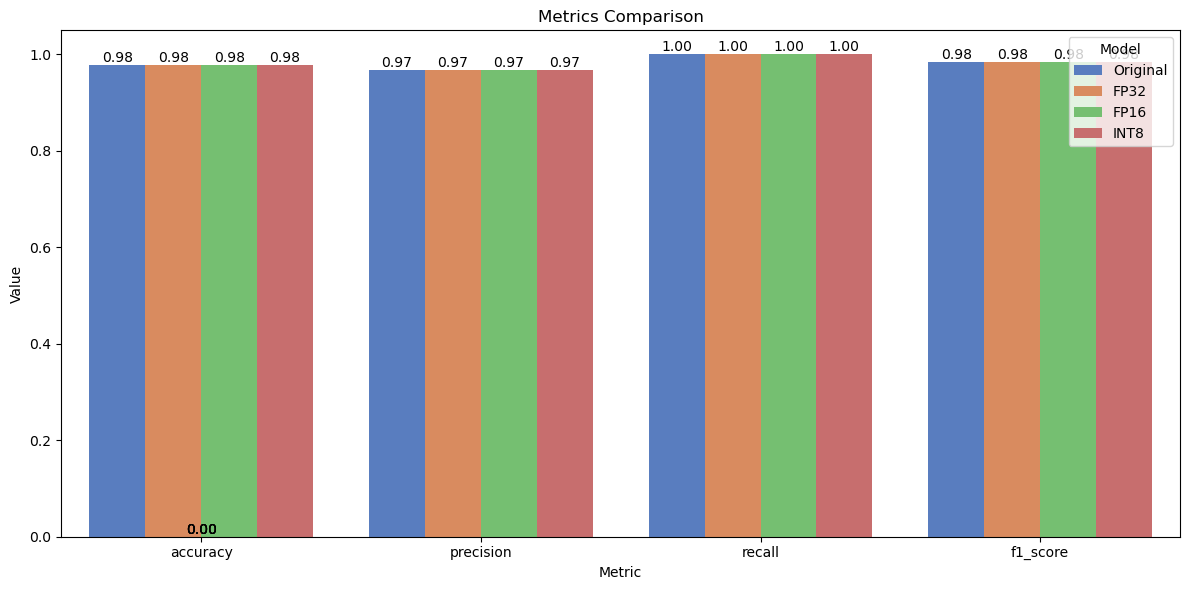


Detailed Metric Changes:
      Model  accuracy  precision  recall  f1_score
0  Original  0.978261   0.967742     1.0  0.983607
1      FP32  0.978261   0.967742     1.0  0.983607
2      FP16  0.978261   0.967742     1.0  0.983607
3      INT8  0.978261   0.967742     1.0  0.983607


In [15]:
graph_model_size(model_sizes_df)  # Pass the DataFrame, not the dictionary
graph_throughput(throughputs_df)  # Pass the DataFrame, not the dictionary
graph_inference_times(average_times_df)
graph_metrics(metrics_data)  